# Beta Estimation

徐子懿

## 1. β理论介绍

### 1.1 CAPM模型与β的定义

CAPM模型由Sharpe（1964），Linter（1965），Mossin（1966）提出，单个资产的期望收益率由三部分构成：
- 无风险收益率
- 市场风险溢价（超额收益率）
- β系数：单个资产对于市场变动的敏感程度，衡量了单个资产对于市场投资组合变化的风险敞口
由公式：
$$
E(r_i) = r_f+ \beta × (E(r_M) - r_f)
$$

### 1.2 β的估计方法

在实际的资产定价中，对于β的估计基于：
$$
R_i = \alpha_i + \beta_i×R_M + e_i
$$
其中，$R_i$为单个资产超额收益率，$R_M$为市场超额收益率，$e_i$为残差项。基于单个资产时间序列数据的回归系数可以完成对单个资产$\beta_i$的估计。通过$\beta$绝对值大小的比较可以得到单个资产对于市场敏感程度。

## 2. 前置准备

### 2.1 加载包

In [2]:
import os
import pandas as pd
import numpy as np
import sqlite3
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed

#可视化数据库
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format
import seaborn as sns
import matplotlib.pyplot as plt

#日期处理
from datetime import datetime

#t检验
from scipy.stats import ttest_ind

### 2.2 数据准备

#### 2.2.1 导入数据

导入月度数据

In [3]:
#读取月度数据
factors_ff3_monthly = pd.read_csv("factors_ff3_monthly.csv")
factors_ff3_monthly['month'] = pd.to_datetime(factors_ff3_monthly['date'], errors='coerce')
factors_ff3_monthly = factors_ff3_monthly[['month', 'mkt_excess']]
factors_ff3_monthly

,month,mkt_excess
0,1960-01-01,-0.0698
1,1960-02-01,0.0117
2,1960-03-01,-0.0163
3,1960-04-01,-0.0171
4,1960-05-01,0.0312
...,...,...
751,2022-08-01,-0.0377
752,2022-09-01,-0.0935
753,2022-10-01,0.0783
754,2022-11-01,0.0460


In [4]:
crsp_monthly = pd.read_csv("crsp_monthly.csv")
crsp_monthly["month"] = pd.to_datetime(crsp_monthly['date'],errors='coerce')
crsp_monthly = crsp_monthly[['permno','month','industry','ret_excess']]
crsp_monthly = crsp_monthly.sort_values(by=['permno','month'])
crsp_monthly

,permno,month,industry,ret_excess
820,10000,1986-02-01,Manufacturing,-0.262443
821,10000,1986-03-01,Manufacturing,0.359385
822,10000,1986-04-01,Manufacturing,-0.103792
823,10000,1986-05-01,Manufacturing,-0.227556
824,10000,1986-06-01,Manufacturing,-0.010225
...,...,...,...,...
3325338,93436,2022-08-01,Public,-0.074389
3323739,93436,2022-09-01,Public,-0.039489
3323740,93436,2022-10-01,Public,-0.144468
3323741,93436,2022-11-01,Public,-0.147226


导入日度数据

In [5]:
factors_ff3_daily = pd.read_csv("factors_ff3_daily.csv", 
                               usecols=['date','mkt_excess'],
                               parse_dates=['date'])
factors_ff3_daily = factors_ff3_daily[['date','mkt_excess']]
factors_ff3_daily["date"] = pd.to_datetime(factors_ff3_daily["date"])
factors_ff3_daily

,date,mkt_excess
0,1960-01-04,-0.0003
1,1960-01-05,0.0078
2,1960-01-06,-0.0047
3,1960-01-07,-0.0065
4,1960-01-08,-0.0033
...,...,...
15853,2022-12-23,0.0051
15854,2022-12-27,-0.0051
15855,2022-12-28,-0.0123
15856,2022-12-29,0.0187


In [6]:
# 读取日频数据
crsp_daily = pd.read_csv("crsp_daily.csv")
crsp_daily["month"] = pd.to_datetime(crsp_daily["date"]).dt.to_period('M').dt.start_time
crsp_daily["date"] = pd.to_datetime(crsp_daily["date"])
crsp_daily = crsp_daily[['permno','month','date','ret_excess']]
crsp_daily = crsp_daily.sort_values(by=['permno','month'])
crsp_daily = crsp_daily[['permno','date','month','ret_excess']]
crsp_daily

,permno,date,month,ret_excess
0,10000.0,1986-01-08,1986-01-01,-0.024640
1,10000.0,1986-01-09,1986-01-01,-0.000250
2,10000.0,1986-01-10,1986-01-01,-0.000250
3,10000.0,1986-01-13,1986-01-01,0.049750
4,10000.0,1986-01-14,1986-01-01,0.047369
...,...,...,...,...
71116730,93436.0,2022-12-23,2022-12-01,-0.017711
71116731,93436.0,2022-12-27,2022-12-01,-0.114249
71116732,93436.0,2022-12-28,2022-12-01,0.032929
71116733,93436.0,2022-12-29,2022-12-01,0.080667


#### 2.2.2 数据连接

In [7]:
#月度数据连接
crsp_monthly = pd.merge(crsp_monthly,factors_ff3_monthly,how="left") # 由于默认按重复键连接，故未列出on参数；左连接实际起到查询作用
crsp_monthly

,permno,month,industry,ret_excess,mkt_excess
0,10000,1986-02-01,Manufacturing,-0.262443,0.0713
1,10000,1986-03-01,Manufacturing,0.359385,0.0488
2,10000,1986-04-01,Manufacturing,-0.103792,-0.0131
3,10000,1986-05-01,Manufacturing,-0.227556,0.0462
4,10000,1986-06-01,Manufacturing,-0.010225,0.0103
...,...,...,...,...,...
3326348,93436,2022-08-01,Public,-0.074389,-0.0377
3326349,93436,2022-09-01,Public,-0.039489,-0.0935
3326350,93436,2022-10-01,Public,-0.144468,0.0783
3326351,93436,2022-11-01,Public,-0.147226,0.0460


In [8]:
#日度数据连接
crsp_daily = pd.merge(crsp_daily,factors_ff3_daily,how="left")
crsp_daily

,permno,date,month,ret_excess,mkt_excess
0,10000.0,1986-01-08,1986-01-01,-0.024640,-0.0216
1,10000.0,1986-01-09,1986-01-01,-0.000250,-0.0117
2,10000.0,1986-01-10,1986-01-01,-0.000250,-0.0002
3,10000.0,1986-01-13,1986-01-01,0.049750,0.0028
4,10000.0,1986-01-14,1986-01-01,0.047369,0.0001
...,...,...,...,...,...
71116730,93436.0,2022-12-23,2022-12-01,-0.017711,0.0051
71116731,93436.0,2022-12-27,2022-12-01,-0.114249,-0.0051
71116732,93436.0,2022-12-28,2022-12-01,0.032929,-0.0123
71116733,93436.0,2022-12-29,2022-12-01,0.080667,0.0187


### 2.3 单个公司数据测试

利用回归方程计算permno==14593公司在整段时间区间上地β值

In [8]:
apple = crsp_monthly[crsp_monthly['permno']==14593]
apple_beta = (smf.ols(
    formula = "ret_excess~mkt_excess",
    data=apple)
.fit())

apple_beta.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ret_excess   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     155.4
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           2.88e-31
Time:                        14:59:53   Log-Likelihood:                 384.99
No. Observations:                 504   AIC:                            -766.0
Df Residuals:                     502   BIC:                            -757.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0102      0.005      2.003      0.046       0.000       0.020
mkt_excess     1.3889      0.111     12.467      0.000       1.170       1.608
==============================================================================
Omnibus:                       19.632   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.358
Skew:                          -0.099   Prob(JB):                     8.58e-11
Kurtosis:                       4.473   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

由此可得，苹果公司在1981-2022年内，β平均为1.4

In [9]:
apple

,permno,month,industry,ret_excess,mkt_excess
376049,14593,1981-01-01,Manufacturing,-0.180418,-0.0504
376050,14593,1981-02-01,Manufacturing,-0.072374,0.0057
376051,14593,1981-03-01,Manufacturing,-0.087217,0.0356
376052,14593,1981-04-01,Manufacturing,0.146560,-0.0211
376053,14593,1981-05-01,Manufacturing,0.152974,0.0011
...,...,...,...,...,...
376548,14593,2022-08-01,Manufacturing,-0.033037,-0.0377
376549,14593,2022-09-01,Manufacturing,-0.122877,-0.0935
376550,14593,2022-10-01,Manufacturing,0.107251,0.0783
376551,14593,2022-11-01,Manufacturing,-0.036029,0.0460


## 3. 月度与日度β估计

### 3.1 滚动窗口函数

#### 3.1.1 滚动窗口介绍

- 采用历史数据估计β——取用多长时间的历史数据？
- 采用一定长度能**充分反映信息、但具有良好时效性**的数据
- 对于不同的β估计，需要选取不同的时间窗口进行轮动——滚动窗口方法

- 用途：常用于处理连续的数据流
- 形式：固定长度，随着时间变化
- 优点：兼顾了数据的充分性与时效性

#### 3.1.2 滚动窗口的程序实践

调用函数：RollingOLS.from_formula
函数参数：
RollingOLS.from(formula,data,window,min_obs)
- formula：函数公式，即回归依据的方法
- data：指定数据
- window：滚动窗口的长度
- min_nobs：存在缺失值的条件下，估计模型所需的最小观测值数量

In [9]:
def roll_capm_estimation(data,window_size,min_obs):
# 首先，对于月频与日频数据进行分别处理，统一化
    if "date" in data.columns:
        data.sort_values( 'date', inplace=True)
    else:
        data.sort_values( 'month', inplace=True) 
# 随后，使用RollingOLS进行滚动回归
    rolling_params = (RollingOLS.from_formula(formula="ret_excess ~ mkt_excess",
      data=data,window=window_size,min_nobs=min_obs).fit() 
    .params["mkt_excess"])
    rolling_params.index = data.index
    return rolling_params

函数解释：
- 定义ret_excess为y变量，mkt_excess为x变量进行回归
- 函数可以自行设定滚动窗格的大小以及用于回归数据的下限

### 3.2 滚动窗口函数测试

选择Apple，Microsoft，Berkshire，Hathaway四家公司的β值作滚动估计

#### 准备测试数据

In [10]:
examples = pd.DataFrame({
    "permno":[14593,10107,93436,17778],
    "company":["Apple","Microsoft",
               "Tesla","Berkshire Hathaway"]
})

test=pd.merge(examples,crsp_monthly,how="left")
test

,permno,company,month,industry,ret_excess,mkt_excess
0,14593,Apple,1981-01-01,Manufacturing,-0.180418,-0.0504
1,14593,Apple,1981-02-01,Manufacturing,-0.072374,0.0057
2,14593,Apple,1981-03-01,Manufacturing,-0.087217,0.0356
3,14593,Apple,1981-04-01,Manufacturing,0.146560,-0.0211
4,14593,Apple,1981-05-01,Manufacturing,0.152974,0.0011
...,...,...,...,...,...,...
1641,17778,Berkshire Hathaway,2022-08-01,Finance,-0.069184,-0.0377
1642,17778,Berkshire Hathaway,2022-09-01,Finance,-0.037119,-0.0935
1643,17778,Berkshire Hathaway,2022-10-01,Finance,0.092615,0.0783
1644,17778,Berkshire Hathaway,2022-11-01,Finance,0.076260,0.0460


#### 估计β值

In [11]:
#设定参数
window_size = 60
min_obs = 48

#滚动估计
beta_test = test.groupby(test["permno"]).apply(lambda x:x.assign(beta = roll_capm_estimation(x,window_size,min_obs))).dropna()
beta_test

C:\Users\15050\AppData\Local\Temp\ipykernel_28400\2829276559.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


permno    company      month  industry  ret_excess  mkt_excess  \
permno                                                                        
10107  563    10107  Microsoft 1991-03-01  Services    0.018492      0.0265   
       564    10107  Microsoft 1991-04-01  Services   -0.072438     -0.0028   
       565    10107  Microsoft 1991-05-01  Services    0.103886      0.0365   
       566    10107  Microsoft 1991-06-01  Services   -0.073107     -0.0494   
       567    10107  Microsoft 1991-07-01  Services    0.073999      0.0424   
...             ...        ...        ...       ...         ...         ...   
93436  1090   93436      Tesla 2022-08-01    Public   -0.074389     -0.0377   
       1091   93436      Tesla 2022-09-01    Public   -0.039489     -0.0935   
       1092   93436      Tesla 2022-10-01    Public   -0.144468      0.0783   
       1093   93436      Tesla 2022-11-01    Public   -0.147226      0.0460   
       1094   93436      Tesla 2022-12-01    Public   -0.370634     -0.0641   

                 beta  
permno                 
10107  563   1.411268  
       564   1.431428  
       565   1.441396  
       566   1.460013  
       567   1.443456  
...               ...  
93436  1090  2.158801  
       1091  2.100328  
       1092  1.972512  
       1093  1.936273  
       1094  2.047437  

[1410 rows x 7 columns]

#### 结果可视化

C:\Users\15050\anaconda3\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


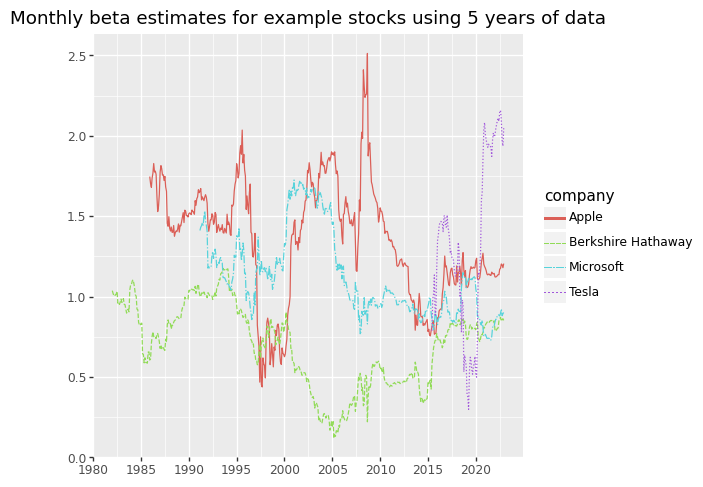

In [13]:
figure_test = (ggplot(beta_test,aes(x="month",y="beta",color="company",linetype="company"))+
geom_line()+
labs(x="", y="",
      title="Monthly beta estimates for example stocks using 5 years of data")+
scale_x_datetime(breaks=date_breaks("5 years"),
                labels=date_format("%Y")))
figure_test.draw()

由此可见，Apple的β处于较高水平，且波动幅度大；伯克希尔公司的整体β值水平低

### 3.3 代码逻辑

#### 并行化处理函数

**原理**：并行化函数是利用计算机的多个核心处理器，将一个程序拆分为多个子任务，这些任务可以在多个CPU上同时运行，从而提高程序的执行速度。

**应用场景**：多个独立的任务，可以平行处理

**函数解释**：

Parallel(

   n_jobs=default(None),  核的个数:最大可选-1，即除一个核外，其它核都在进行并行化任务

   backend=default(None), 在Python中，有很多库可以用来进行并行计算，例如 multiprocessing, joblib, dask 等这里的 "ParallelBackendBase instance or None, default: 'loky'" 是在说你可以指定一个并行计算的后端实现, 如果不指定，默认使用 'loky' 这个后端。

   return_as='list', # 可选list或者generator，后者可以随时返回可用值而不用等所有结果都运算完。

   verbose=default(0), # 如果这个参数不是零，那么程序会打印出进度信息。

   timeout=None, # 超时限制通常用于控制一项任务在特定时间内完成。如果在指定的时间内任务没有完成，那么会抛出一个超时错（TimeoutError）
)

delayed( )：将函数调用推迟到并行处理的过程中，确保在每个进程中只导入一次v函数，并在需要时进行调用。

#### transform函数

- transform函数接受单一参数，作为替换计算的公式
- transform函数的作用是对于可迭代对象中的元素进行转换，将每个元素替换为转换后的结果
- transform函数常用于表格内的简单变换或广播分组结果

#### 代码逻辑

**整体目标**：滚动窗口计算β
- 理论顺序：逐行第一步选取窗口，第二部计算β值
- 实际操作：引入**并行化处理函数**，同时处理好每个窗格的信息，同时计算β值

**代码实现**：
- 对于所有的数据做好筛选以及按照公司分组
- 对于每个分组内部，按照rolling_capm_estimation滚动计算β值
- 对于所有任务，调用并行化函数进行处理

### 3.4 函数设计

首先定义函数处理单组，随后筛选整体数据，对于整体数据进行迭代

#### 3.4.1 定义单个任务内部函数

In [12]:
# 首先定义一个针对每一个permno的函数（即子任务内部的处理）
def roll_capm_estimation_for_joblib(name,group):
    #首先，完成beta的滚动估计
    beta = roll_capm_estimation(group,window_size,min_obs)
    #其后，创建dataframe，储存结果信息
    result = pd.DataFrame()
    result["month"] = group["month"]
    result["permno"] = group["permno"]
    result["beta"] = beta
    #最后，日度数据中每月只保留最后一天的数据，后续用于跟月频数据比对
    try:
        result["date"] = group["date"].values
        result = result[
        (result.groupby("month")["date"]
          .transform("max")) == result["date"]]  # 对于日度数据，只保留了每月最后一天的值
    except(KeyError):
        pass
    result.dropna()
    return result
    result.dropna()
    return result

#### 3.4.2 数据筛选

- 针对公司层面进行筛选，公司数据数量须高于窗口长度
- 在公司层面进行分组，每个公司的数据分开，为并行化处理做准备

In [13]:
# 月度数据筛选
# 按照条件筛选
valid_permnos = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
# 按照公司分组
grouped_data = (crsp_monthly
  .merge(valid_permnos, how="inner", on="permno")
  .dropna()
  .groupby("permno")
)

**函数补充：query函数**
- 函数形式：DataFrame.query(expr,inplace=TRUE,**kwargs)
- 主要参数：expr：输入查询条件，语言简洁直观，为一个字符串
- 引用外部变量：@变量名，可以轻松引用外部定义的变量

#### 3.4.3 计算β
应用并行化函数Parallel最终得到月频beta

In [17]:
beta_monthly = (pd.concat(Parallel(n_jobs=-3,
                                   backend="loky",
                                   verbose=8)(delayed(roll_capm_estimation_for_joblib)(name,group)for name,group in grouped_data)).dropna())
beta_monthly

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-3)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-3)]: Done 164 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-3)]: Done 512 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-3)]: Done 1456 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-3)]: Done 2528 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-3)]: Done 3760 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-3)]: Done 5120 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-3)]: Done 6640 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-3)]: Done 8288 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-3)]: Done 10096 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-3)]: Done 12032 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-3)]: Done 14128 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-3)]: Done 15137 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-3)]: Done 15293 out of 

,month,permno,beta
59,1991-01-01,10001,0.097436
60,1991-02-01,10001,0.094800
61,1991-03-01,10001,0.089890
62,1991-04-01,10001,0.088488
63,1991-05-01,10001,0.091946
...,...,...,...
2995432,2022-08-01,93436,2.158801
2995433,2022-09-01,93436,2.100328
2995434,2022-10-01,93436,1.972512
2995435,2022-11-01,93436,1.936273


In [18]:
beta_monthly.rename(columns={'beta':'beta_monthly'},inplace=True)
beta_monthly

,month,permno,beta_monthly
59,1991-01-01,10001,0.097436
60,1991-02-01,10001,0.094800
61,1991-03-01,10001,0.089890
62,1991-04-01,10001,0.088488
63,1991-05-01,10001,0.091946
...,...,...,...
2995432,2022-08-01,93436,2.158801
2995433,2022-09-01,93436,2.100328
2995434,2022-10-01,93436,1.972512
2995435,2022-11-01,93436,1.936273


同理，日频β的计算

In [14]:
window_size = 60
min_obs = 50

# 日度数据的筛选
valid_permnos2 = (crsp_daily
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
grouped_data_daily = (crsp_daily
  .merge(valid_permnos2, how="inner", on="permno")
  .dropna()
  .groupby("permno")
)

In [15]:
# 日度β的计算
beta_daily = (pd.concat(Parallel(n_jobs=-1,
        backend="loky",
        verbose=8)(delayed(roll_capm_estimation_for_joblib)(name,group)for name,group in grouped_data_daily)).dropna())
beta_daily.rename(columns={'beta':'beta_daily'},inplace=True)
beta_daily

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 414 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 509 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 725 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 846 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 977 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1116 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1265 tasks      | elapsed:

,month,permno,beta_daily,date
78,1986-04-01,10000.0,0.005527,1986-04-30
99,1986-05-01,10000.0,0.003349,1986-05-30
120,1986-06-01,10000.0,-0.020345,1986-06-30
142,1986-07-01,10000.0,0.600559,1986-07-31
163,1986-08-01,10000.0,0.650888,1986-08-29
...,...,...,...,...
71112108,2022-08-01,93436.0,1.702458,2022-08-31
71112129,2022-09-01,93436.0,1.515607,2022-09-30
71112150,2022-10-01,93436.0,1.265084,2022-10-31
71112171,2022-11-01,93436.0,1.417427,2022-11-30


In [19]:
beta = (beta_monthly
  .get(["permno", "month", "beta_monthly"])
  .merge(beta_daily.get(["permno", "month", "beta_daily"]),
         how="outer",
         on=["permno", "month"])
)
beta

,permno,month,beta_monthly,beta_daily
0,10000.0,1986-04-01,NaN,0.005527
1,10000.0,1986-05-01,NaN,0.003349
2,10000.0,1986-06-01,NaN,-0.020345
3,10000.0,1986-07-01,NaN,0.600559
4,10000.0,1986-08-01,NaN,0.650888
...,...,...,...,...
3338935,93436.0,2022-08-01,2.158801,1.702458
3338936,93436.0,2022-09-01,2.100328,1.515607
3338937,93436.0,2022-10-01,1.972512,1.265084
3338938,93436.0,2022-11-01,1.936273,1.417427


## 4. β值的比较

我们拿到的数据分为如下维度：
- 时间维度：月频/日频，可比较两者的表现/不同时间区间的表现
- 公司维度：行业类别-公司，可比较行业间/公司间表现

### 4.1 不同行业β值的比较

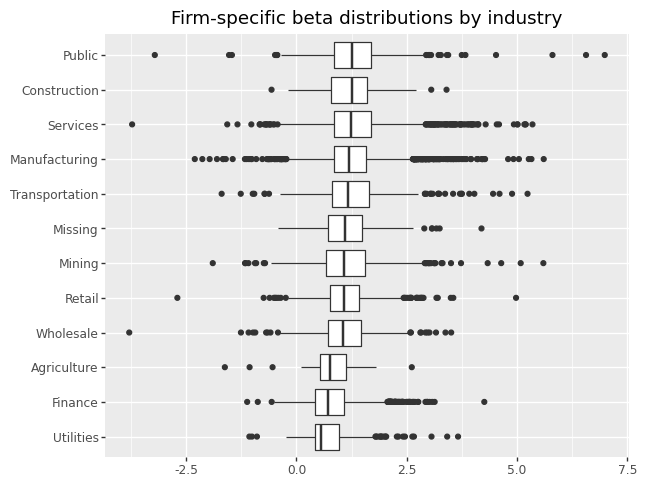

In [21]:
# 按照行业进行分组
beta_industries = (beta_monthly
  .merge(crsp_monthly, how="inner", on=["permno", "month"])
  .dropna(subset="beta_monthly")
  .groupby(["industry","permno"])["beta_monthly"]
  .aggregate("mean")
  .reset_index()
)

industry_order = (beta_industries
  .groupby("industry")["beta_monthly"]
  .aggregate("median").sort_values()
  .index.tolist()
)

# 绘制箱线图
plot_beta_industries = (
  ggplot(beta_industries, 
         aes(x="industry", y="beta_monthly")) +
  geom_boxplot() +
  coord_flip() +
  scale_x_discrete(limits=industry_order) +
  labs(x="", y="", 
       title="Firm-specific beta distributions by industry")
)
plot_beta_industries.draw()

**结论**：
- 不同行业之间β相差不大；
- 公用事业（电力）等行业β较小，可能源于：政府监管/负债较高，增长空间相对较小/稳定的供给与业绩/属于防御性板块

### 4.2 不同时期β历史表现

C:\Users\15050\anaconda3\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


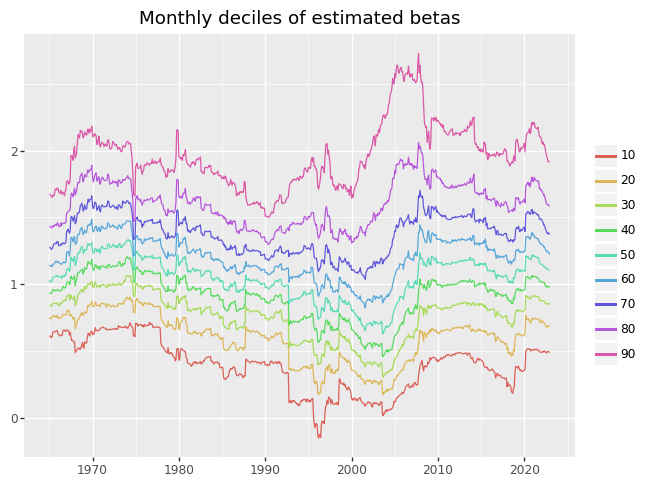

In [22]:
beta_quantiles = (beta_monthly
  .groupby("month")["beta_monthly"]
  .quantile(q=np.arange(0.1, 1.0, 0.1))
  .reset_index()
  .rename(columns={"level_1": "quantile"})
  .assign(
    quantile=lambda x: (x["quantile"] * 100).astype(int)
  )
  .dropna()
)

plot_beta_quantiles = (
  ggplot(beta_quantiles, 
         aes(x="month", y="beta_monthly", 
             color="factor(quantile)")) +
  geom_line() +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title="Monthly deciles of estimated betas")
)
plot_beta_quantiles.draw()

按照β的历史表现划分为等分数。可以得到如下信息：
- 有些时段β的差异较小，有些时候差异很大；
- 不同时段表现出了不同的趋势性；
- 从1970年-2020年，β呈现周期性震荡

### 4.3 日度与月度β估计值的比较

C:\Users\15050\anaconda3\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


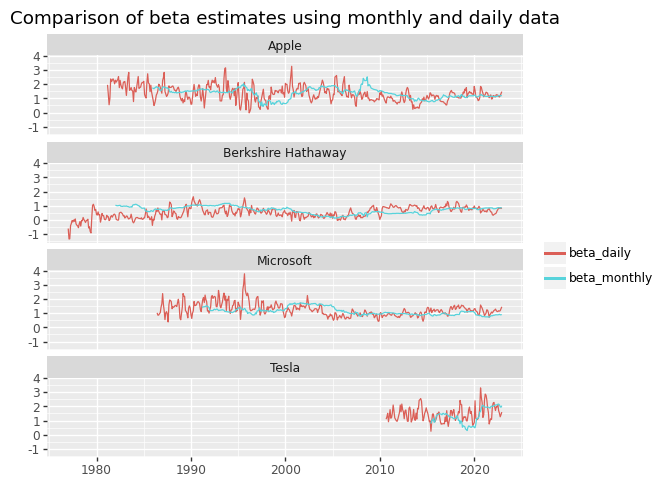

In [23]:
beta = (beta_monthly
  .get(["permno", "month", "beta_monthly"])
  .merge(beta_daily.get(["permno", "month", "beta_daily"]),
         how="outer",
         on=["permno", "month"])
)

beta_comparison = (beta
  .merge(examples, on="permno")
  .melt(id_vars=["permno", "month", "company"],
        value_vars=["beta_monthly", "beta_daily"],
        var_name="name", value_name="value")
  .dropna()
)

plot_beta_comparison = (
  ggplot(beta_comparison,
         aes(x="month", y="value", color="name")) +
  geom_line() +
  facet_wrap("~company", ncol=1) +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x="", y="", color="",
       title=("Comparison of beta estimates using monthly "
              "and daily data"))
)
plot_beta_comparison.draw()

结论：
- 选取了四家公司，可以发现苹果公司的总体β水平较高，波动率也较高；
- 相比来说，日频β波动性大于月频β，但日频和月频数据总体走势一致

### 4.4 稳健性检验

检验内容：每个时间段有百分之多少的股票存在有效估计值

C:\Users\15050\anaconda3\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


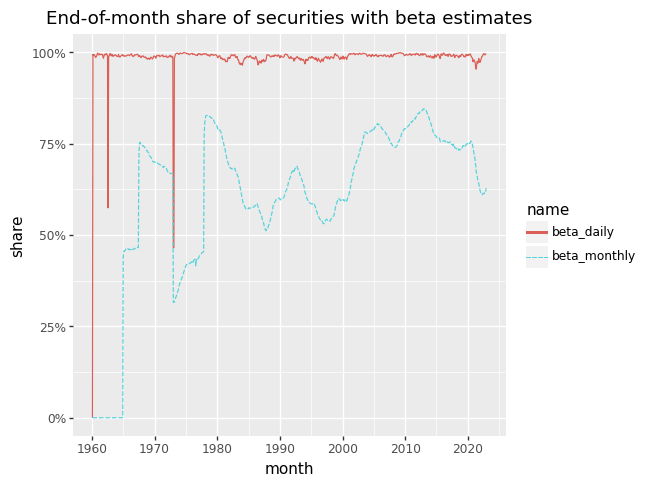

In [24]:
beta_long = (crsp_monthly
  .merge(beta, how="left", on=["permno", "month"])
  .melt(id_vars=["permno", "month"],
        value_vars=["beta_monthly", "beta_daily"],
        var_name="name", value_name="value")
  .groupby(["month", "name"])
  .aggregate(
    share=("value", lambda x: sum(~x.isna()) / len(x))
  )
  .reset_index()
)

plot_beta_long = (
  ggplot(beta_long, 
         aes(x="month", y="share", color="name", 
             linetype="name")) +
  geom_line() +
  scale_y_continuous(labels=percent_format()) +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x=None, y=None, color=None, linetype=None,
       title=("End-of-month share of securities with beta "
              "estimates"))
)
plot_beta_long.draw()

可以通过对于覆盖率的描述性统计得到beta是否有效

In [98]:
beta_long.groupby("name")["share"].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
beta_bymonth_4,755.0,0.606504,0.213694,0.0,0.546678,0.668273,0.753688,0.845352
beta_bymonth_5,755.0,0.606504,0.213694,0.0,0.546678,0.668273,0.753688,0.845352
beta_monthly,755.0,0.606504,0.213694,0.0,0.546678,0.668273,0.753688,0.845352


In [20]:
beta.get(["beta_monthly", "beta_daily"]).corr()

,beta_monthly,beta_daily
beta_monthly,1.000000,0.314997
beta_daily,0.314997,1.000000


beta覆盖度高，月度和日度β成正相关关系

# 5. 练习

### 5.1 使用1年、3年和5年的数据根据​​每月数据计算beta估计值，并分别对返回数据施加10、28和48个月的最小观察次数。贝塔估计值的相关性有多强？

- 计算一年和三年的β
- 用corr函数求出相关系数

In [27]:
#一年的
window_size = 12
min_obs = 10

valid_permnos_monthly_1 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_1 = (crsp_monthly
  .merge(valid_permnos_monthly_1, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_1 = (
    permno_groups_monthly_1
    .apply(lambda group: group.assign(beta_bymonth_1=roll_capm_estimation(group, window_size, min_obs)))
    .dropna()
)

C:\Users\15050\AppData\Local\Temp\ipykernel_7744\3750489181.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [28]:
#三年的
window_size = 36
min_obs = 28
# 更改数据窗口为3年，并需要至少28个月的数据来计算

valid_permnos_monthly_2 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_2 = (crsp_monthly
  .merge(valid_permnos_monthly_2, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_2 = (
    permno_groups_monthly_2
    .apply(lambda group: group.assign(beta_bymonth_2=roll_capm_estimation(group, window_size, min_obs)))
    # 在所有分组上应用函数roll_capm_estimation
    .dropna()
)

C:\Users\15050\AppData\Local\Temp\ipykernel_7744\4223821084.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [29]:
estimated_betas = (beta_monthly
.merge(beta_monthly_1, how="inner", on=["permno", "month"])
.merge(beta_monthly_2, how="inner", on=["permno", "month"])
)
estimated_betas.rename(columns={'beta_monthly': 'beta_bymonth_3'}, inplace=True)

In [30]:
estimated_betas.get(["beta_bymonth_1", "beta_bymonth_2", "beta_bymonth_3"]).corr()

,beta_bymonth_1,beta_bymonth_2,beta_bymonth_3
beta_bymonth_1,1.000000,0.571240,0.466984
beta_bymonth_2,0.571240,1.000000,0.826302
beta_bymonth_3,0.466984,0.826302,1.000000


### 5.2 用五年数据，使用不同的最小观测值观测β，观察结果有什么不同，它们之间有相关性吗

更换最小的观测值，发现三者结果相同

In [75]:
window_size = 60
min_obs = 42

valid_permnos_monthly_4 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_4 = (crsp_monthly
  .merge(valid_permnos_monthly_4, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_4 = (
    permno_groups_monthly_4
    .apply(lambda group: group.assign(beta_bymonth_4=roll_capm_estimation(group, window_size, min_obs)))
    .dropna()
)

C:\Users\15050\AppData\Local\Temp\ipykernel_7744\2860979052.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [77]:
window_size = 60
min_obs = 54

valid_permnos_monthly_5 = (crsp_monthly
  .groupby("permno")["permno"]
  .count()
  .reset_index(name="counts")
  .query("counts > @window_size + 1")
)
permno_groups_monthly_5 = (crsp_monthly
  .merge(valid_permnos_monthly_5, how="inner", on="permno")
  .dropna()
  .groupby("permno", group_keys=False)
)

beta_monthly_5 = (
    permno_groups_monthly_5
    .apply(lambda group: group.assign(beta_bymonth_5=roll_capm_estimation(group, window_size, min_obs)))
    .dropna()
)

C:\Users\15050\AppData\Local\Temp\ipykernel_7744\2018075783.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [64]:
estimated_betas = (beta_monthly
.merge(beta_monthly_4, how="inner", on=["permno", "month"])
.merge(beta_monthly_5, how="inner", on=["permno", "month"])
)
estimated_betas.rename(columns={'beta_monthly': 'beta_bymonth_3'}, inplace=True)

In [65]:
estimated_betas.get(["beta_bymonth_3", "beta_bymonth_4", "beta_bymonth_5"]).corr()

,beta_bymonth_3,beta_bymonth_4,beta_bymonth_5
beta_bymonth_3,1.0,1.0,1.0
beta_bymonth_4,1.0,1.0,1.0
beta_bymonth_5,1.0,1.0,1.0


In [59]:
beta_2 = (beta_monthly
  .get(["permno", "month", "beta_monthly"])
  .merge(beta_monthly_4.get(["permno", "month", "beta_bymonth_4"])
  .merge(beta_monthly_5.get(["permno", "month", "beta_bymonth_5"]),
         how="outer",
         on=["permno", "month"])
)
         )

beta_long_1 = (crsp_monthly
  .merge(beta_2, how="left", on=["permno", "month"])
  .melt(id_vars=["permno", "month"],
        value_vars=["beta_monthly", "beta_bymonth_4","beta_bymonth_5"],
        var_name="name", value_name="value")
  .groupby(["month", "name"])
  .aggregate(
    share=("value", lambda x: sum(~x.isna()) / len(x))
  )
  .reset_index()
)

C:\Users\15050\anaconda3\Lib\site-packages\mizani\breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


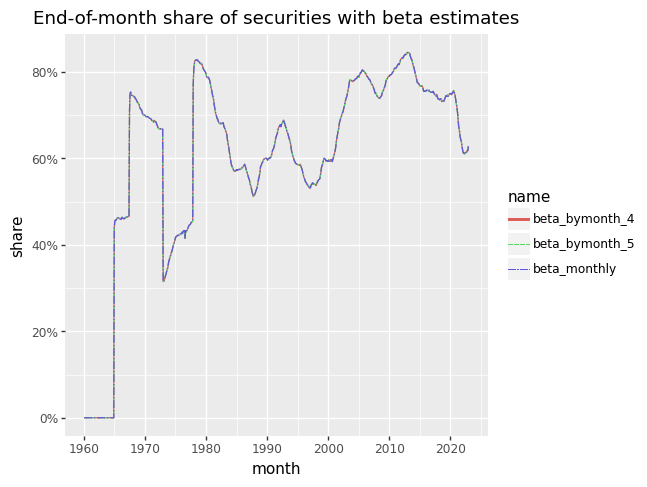

In [60]:
plot_beta_long_1 = (
  ggplot(beta_long_1, 
         aes(x="month", y="share", color="name", 
             linetype="name")) +
  geom_line() +
  scale_y_continuous(labels=percent_format()) +
  scale_x_datetime(breaks=date_breaks("10 year"), 
                   labels=date_format("%Y")) +
  labs(x=None, y=None, color=None, linetype=None,
       title=("End-of-month share of securities with beta "
              "estimates"))
)
plot_beta_long_1.draw()

### 5.3 选取100个permnos，验证循环与并行化函数运行的结果相同

首先，选取100个满足要求的permnos，这里选取前100个

In [70]:
top_100_permnos = crsp_monthly["permno"].drop_duplicates().head(100)
valid_permnos = (
    crsp_monthly
    .groupby("permno")["permno"]
    .count()
    .reset_index(name="counts")
    .query("counts > @window_size + 1")
)

# 取前 100 个 permno
top_100_permnos = valid_permnos.head(100)["permno"]

# 筛选数据并按 permno 分组
grouped_data = (
    crsp_monthly
    .merge(valid_permnos, how="inner", on="permno")
    .query("permno in @top_100_permnos")  # 只保留前 100 个 permno 的数据
    .dropna()
    .groupby("permno")  # 按 permno 分组
)

采用parallel函数（并行化方法）

In [71]:
beta_monthly = (pd.concat(Parallel(n_jobs=-3,
                                   backend="loky",
                                   verbose=8)(delayed(roll_capm_estimation_for_joblib)(name,group)for name,group in grouped_data)).dropna())
beta_monthly

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-3)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-3)]: Done  56 out of 100 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-3)]: Done  95 out of 100 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-3)]: Done 100 out of 100 | elapsed:    1.2s finished


,month,permno,beta
59,1991-01-01,10001,0.097436
60,1991-02-01,10001,0.094800
61,1991-03-01,10001,0.089890
62,1991-04-01,10001,0.088488
63,1991-05-01,10001,0.091946
...,...,...,...
20266,2003-01-01,10160,1.355263
20267,2003-02-01,10160,1.409623
20268,2003-03-01,10160,1.372839
20269,2003-04-01,10160,1.306497


调用apply函数进行循环

In [74]:
beta_monthly_100 = (
    grouped_data
    .apply(lambda group: group.assign(beta_bymonth_100=roll_capm_estimation(group, window_size, min_obs)))
    .dropna()
)
beta_monthly_100 = beta_monthly_100[["month","permno","beta_bymonth_100"]]
beta_monthly_100

C:\Users\15050\AppData\Local\Temp\ipykernel_7744\562140355.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


month  permno  beta_bymonth_100
permno                                           
10001  59    1991-01-01   10001          0.097436
       60    1991-02-01   10001          0.094800
       61    1991-03-01   10001          0.089890
       62    1991-04-01   10001          0.088488
       63    1991-05-01   10001          0.091946
...                 ...     ...               ...
10160  20266 2003-01-01   10160          1.355263
       20267 2003-02-01   10160          1.409623
       20268 2003-03-01   10160          1.372839
       20269 2003-04-01   10160          1.306497
       20270 2003-05-01   10160          1.252125

[14371 rows x 3 columns]

容易得到，两者计算结果完全一致

### 5.4 过滤掉β为负的股票。这些股票是否经常表现出负贝塔，还是估计错误

In [32]:
# 根据'permno'分组，然后使用all()函数筛选出每个分组中'beta_bymonth'存在小于0的行
filtered_beta_monthly = beta_monthly[beta_monthly['beta_monthly'] < 0]
filtered_beta_monthly.groupby('permno').count().sort_values('month',ascending=False)

,month,beta_monthly
permno,,
11593,191,191
70704,146,146
49322,145,145
64442,145,145
48072,143,143
...,...,...
77248,1,1
10596,1,1
77307,1,1


In [33]:
permnos_have_negative_beta = pd.DataFrame({"permno": [11593,70704,49322,64442]})
Negative_beta_example = (beta_monthly
  .merge(permnos_have_negative_beta, how="inner", on="permno")
  .dropna()
)
Negative_beta_example['permno'] = Negative_beta_example['permno'].astype(str)

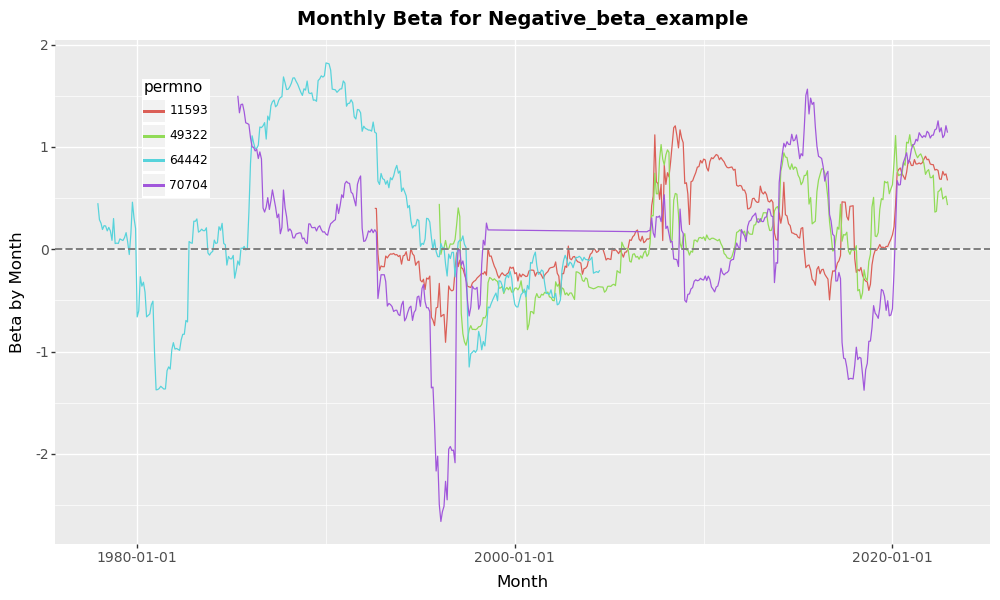

In [41]:
# 绘制月度beta走势图
plot = (
    ggplot(Negative_beta_example, aes(x='month', y='beta_monthly', color='factor(permno)'))
    + geom_line()
    + geom_hline(yintercept=0, color='gray', linetype='dashed', size=0.8)
    + labs(
        title='Monthly Beta for Negative_beta_example',
        x='Month',
        y='Beta by Month',
        color='permno'
    )
    + theme(
        figure_size=(10, 6),
        legend_position=(0.1, 0.9),  # 自定义图例位置，相对于图形 (x, y)
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        plot_title=element_text(size=14, weight='bold')
    )
)

# 使用 matplotlib 显示图像
plot.draw()


由图可知，β为负来自于短时间的市场震荡。这些股票整体波动性较大

In [55]:
permno_with_negative = filtered_beta_monthly['permno'].unique()
all_positive = beta_monthly[~beta_monthly['permno'].isin(permno_with_negative)]
contains_negative = beta_monthly[beta_monthly['permno'].isin(permno_with_negative)]

# 2. 计算波动率（标准差）并按 permno 汇总
all_positive_volatility = all_positive.groupby('permno')['beta_monthly'].std()
contains_negative_volatility = contains_negative.groupby('permno')['beta_monthly'].std()

# 3. 显著性检验
t_stat, p_value = ttest_ind(all_positive_volatility, contains_negative_volatility, equal_var=False)
print("全为正的波动率：")
print(all_positive_volatility.describe())
print("\n存在负数的波动率：")
print(contains_negative_volatility.describe())
print("\nT 检验结果：")
print("t-statistic:", t_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n结论：两组波动率之间存在显著差异 (p < 0.05)。")
else:
    print("\n结论：两组波动率之间不存在显著差异 (p >= 0.05)。")

全为正的波动率：
count    12003.000000
mean         0.304331
std          0.226172
min          0.001533
25%          0.148036
50%          0.254862
75%          0.401068
max          2.751670
Name: beta_monthly, dtype: float64

存在负数的波动率：
count    3290.000000
mean        0.484445
std         0.299392
min         0.007259
25%         0.277332
50%         0.433837
75%         0.619422
max         3.418085
Name: beta_monthly, dtype: float64

T 检验结果：
t-statistic: -32.08840481881077
p-value: 4.734959442985022e-203

结论：两组波动率之间存在显著差异 (p < 0.05)。


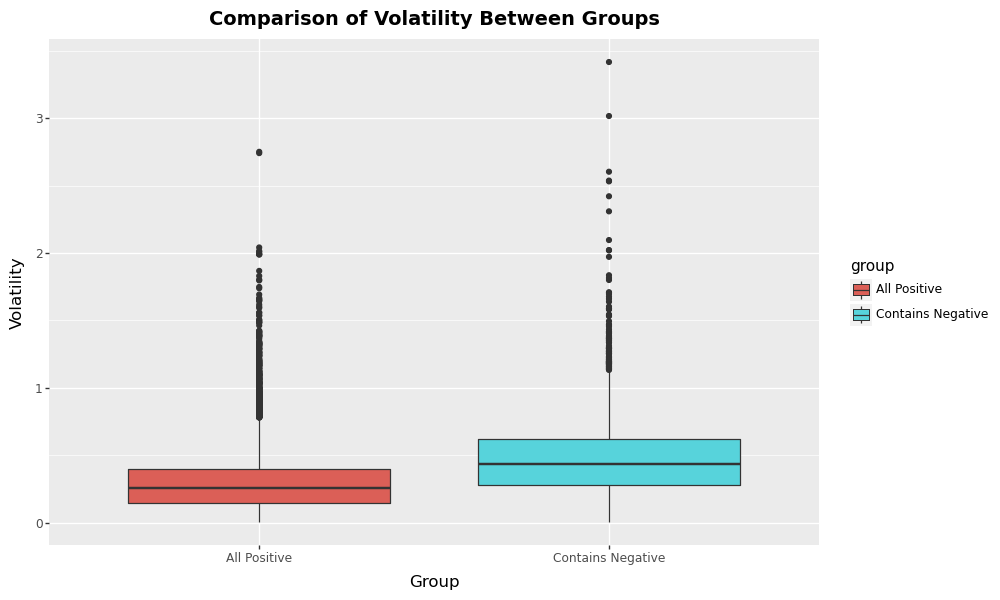

In [54]:
all_positive_volatility = all_positive_volatility.reset_index().rename(columns={0: 'volatility'})
contains_negative_volatility = contains_negative_volatility.reset_index().rename(columns={0: 'volatility'})

all_positive_volatility['group'] = 'All Positive'
contains_negative_volatility['group'] = 'Contains Negative'

combined_data = pd.concat([all_positive_volatility, contains_negative_volatility])

boxplot = (
    ggplot(combined_data, aes(x='group', y='volatility', fill='group'))
    + geom_boxplot()
    + labs(
        title='Comparison of Volatility Between Groups',
        x='Group',
        y='Volatility'
    )
    + theme(
        figure_size=(10, 6),
        axis_title=element_text(size=12),
        plot_title=element_text(size=14, weight='bold')
    )
)

boxplot.draw()

### 5.5 计算多因子模型（如Fama-French三因子模型）的β估计值

In [60]:
#重新导入数据
three_factors_ff3_monthly = pd.read_csv('factors_ff3_monthly.csv')
three_factors_ff3_monthly['month'] = pd.to_datetime(three_factors_ff3_monthly['date'], errors='coerce')
crsp_monthly = pd.read_csv("crsp_monthly.csv")
crsp_monthly["month"] = pd.to_datetime(crsp_monthly['date'],errors='coerce')
crsp_monthly = crsp_monthly[['permno','month','ret_excess']]
crsp_monthly = crsp_monthly.sort_values(by=['permno','month'])
merged_dataff3_monthly = pd.merge(crsp_monthly, three_factors_ff3_monthly, how='left', on='month')
merged_dataff3_monthly = merged_dataff3_monthly[["permno","month","ret_excess","mkt_excess","smb","hml","rf"]]
merged_dataff3_monthly

,permno,month,ret_excess,mkt_excess,smb,hml,rf
0,10000,1986-02-01,-0.262443,0.0713,-0.0054,-0.0072,0.0053
1,10000,1986-03-01,0.359385,0.0488,-0.0059,-0.0039,0.0060
2,10000,1986-04-01,-0.103792,-0.0131,0.0278,-0.0287,0.0052
3,10000,1986-05-01,-0.227556,0.0462,-0.0135,-0.0021,0.0049
4,10000,1986-06-01,-0.010225,0.0103,-0.0096,0.0128,0.0052
...,...,...,...,...,...,...,...
3326348,93436,2022-08-01,-0.074389,-0.0377,0.0140,0.0029,0.0019
3326349,93436,2022-09-01,-0.039489,-0.0935,-0.0081,0.0005,0.0019
3326350,93436,2022-10-01,-0.144468,0.0783,0.0006,0.0801,0.0023
3326351,93436,2022-11-01,-0.147226,0.0460,-0.0352,0.0138,0.0029


In [61]:
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess + smb + hml", # 这里的模型变化为对‘mkt_excess’、‘smb’、‘hml’三因子进行多元回归
    data=merged_dataff3_monthly.query("permno == 14593"))
  .fit()
)
print(model_beta.summary())

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     66.44
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           3.60e-36
Time:                        21:50:38   Log-Likelihood:                 401.56
No. Observations:                 504   AIC:                            -795.1
Df Residuals:                     500   BIC:                            -778.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0136      0.005      2.733      0.0

In [62]:
model_beta = (smf.ols(
    formula="ret_excess ~ mkt_excess + smb + hml",
    data=merged_dataff3_monthly)
.fit()
)
print(model_beta.summary())

                            OLS Regression Results                            
Dep. Variable:             ret_excess   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                 1.189e+05
Date:                Tue, 19 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:51:01   Log-Likelihood:             1.0997e+06
No. Observations:             3326353   AIC:                        -2.199e+06
Df Residuals:                 3326349   BIC:                        -2.199e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002   9.72e-05      1.897      0.0

## 6. 小结

![Structure](Structure.png)